In [3]:
import numpy as np

data_aug = np.load('/mnt/proj\Diffusion_DGCL\Data/aug_train/full-0.2-500.npy')
print(data_aug.shape)
data_raw = np.load('/mnt/proj/Diffusion_DGCL\Data/train/train-0.2.npz')
data_1 = data_raw['data']
target_1 = data_raw['target']
print(data_1.shape)
print(target_1.shape)

combined_data = np.vstack([data_aug, data_1])
target1 = np.ones(data_aug.shape[0]).astype(np.int64)
combined_target = np.concatenate([target1, target_1])

print(combined_data.shape)
print(combined_target.shape)

np.savez_compressed("/mnt/proj/Diffusion_DGCL\Data/train/train.npz", data=combined_data, target=combined_target)


(287, 256, 23)
(5907, 256, 23)
(5907,)
(6194, 256, 23)
(6194,)


In [4]:
import numpy as np

# Cargar el dataset de entrenamiento
train_data = np.load('/mnt/proj/Diffusion_DGCL\Data/train/train.npz')
X_train = train_data['target']
y_train = train_data['data']

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)

Shape of X_train: (6194,)
Shape of y_train: (6194, 256, 23)


In [5]:
# 获取所有类别及其样本数
unique_classes = np.unique(X_train)
num_classes = len(unique_classes)
print("类别总数:", num_classes)
print("类别列表:", unique_classes)

# 统计每个类别的样本数量
class_counts = {class_label: np.sum(X_train == class_label) for class_label in unique_classes}
print("每个类别的样本数:", class_counts)


类别总数: 2
类别列表: [0 1]
每个类别的样本数: {0: 5189, 1: 1005}


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

# Definir la forma de entrada
input_shape = (y_train.shape[1], y_train.shape[2])

model = Sequential([
    Input(shape=input_shape),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
test_dataset = np.load(r'/mnt/proj/Diffusion_DGCL\Data/test/full-500.npz')
data_test = test_dataset['data']
target_test = test_dataset['target']

model.fit(y_train, X_train, 
          validation_data=(data_test, target_test),
          epochs=10, 
          batch_size=32)


Epoch 1/10
194/194 [==============================] - 34s 165ms/step - loss: 0.3936 - accuracy: 0.8602 - val_loss: 0.5360 - val_accuracy: 0.7857
Epoch 2/10
194/194 [==============================] - 30s 155ms/step - loss: 0.3434 - accuracy: 0.8846 - val_loss: 0.5518 - val_accuracy: 0.7914
Epoch 3/10
194/194 [==============================] - 29s 151ms/step - loss: 0.3168 - accuracy: 0.8881 - val_loss: 0.5471 - val_accuracy: 0.7986
Epoch 4/10
194/194 [==============================] - 29s 152ms/step - loss: 0.2990 - accuracy: 0.8962 - val_loss: 0.5209 - val_accuracy: 0.8000
Epoch 5/10
194/194 [==============================] - 33s 170ms/step - loss: 0.2827 - accuracy: 0.9014 - val_loss: 0.5789 - val_accuracy: 0.8014
Epoch 6/10
194/194 [==============================] - 33s 168ms/step - loss: 0.2694 - accuracy: 0.9057 - val_loss: 0.5665 - val_accuracy: 0.7971
Epoch 7/10
194/194 [==============================] - 34s 178ms/step - loss: 0.2571 - accuracy: 0.9068 - val_loss: 0.5741 - val_ac

In [8]:
# Evaluar el modelo en el conjunto de validación balanceado
val_balanced_loss, val_balanced_accuracy = model.evaluate(data_test, target_test)
print(f"Validation Balanced Loss: {val_balanced_loss}")
print(f"Validation Balanced Accuracy: {val_balanced_accuracy}")

22/22 [==============================] - 1s 52ms/step - loss: 0.7084 - accuracy: 0.8043
Validation Balanced Loss: 0.7083882093429565
Validation Balanced Accuracy: 0.8042857050895691


22/22 [==============================] - 1s 45ms/step
              precision    recall  f1-score   support

           0       0.73      0.97      0.83       350
           1       0.95      0.64      0.77       350

    accuracy                           0.80       700
   macro avg       0.84      0.80      0.80       700
weighted avg       0.84      0.80      0.80       700


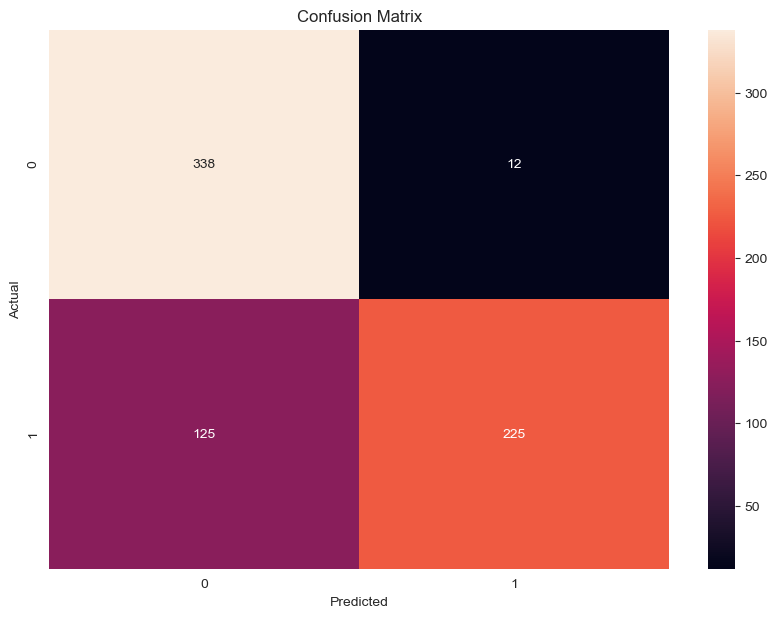

ROC-AUC Score: 0.8279510204081634


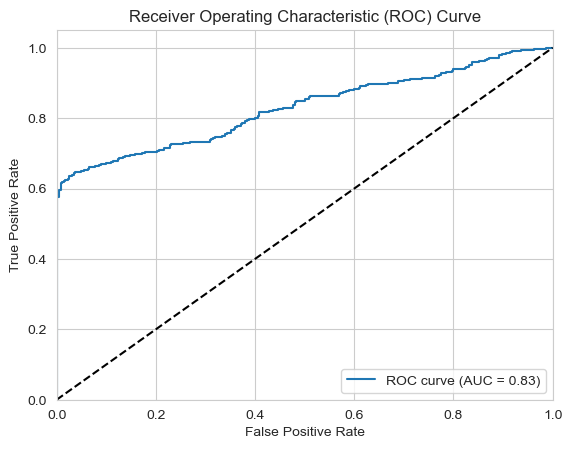

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Hacer predicciones
y_pred_prob = model.predict(data_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calcular métricas adicionales
print(classification_report(target_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(target_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC-AUC score
auc_roc = roc_auc_score(target_test, y_pred_prob)
print(f"ROC-AUC Score: {auc_roc}")

# Curva ROC
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(target_test, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_roc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()